## Análise comparativa entre os métodos de segmentação

Neste notebook, realizaremos uma análise comparativa entre ambos os métodos de segmentação. Os conceitos gerais e funcionamento de ambos os métodos podem ser consultados em maiores detalhes nos [Notebook com análise do Chan-vese](Analise_Casos_Chan_Vese.ipynb) e [Notebook com análise para o Watershed](Analise_Casos_Watershed.ipynb). Desta forma, o foco deste notebook é ter uma demonstração lado a lado das avalições quantitativas e qualitativas de ambos os métodos.

Assim como nos notebooks especificos de cada método citados acima, a avaliação será demonstrada para cada caso de teste. Contudo, neste notebook eles serão executados para ambos os métodos juntamente.

A seguir, iremos definir as funções como feito nos notebooks especificos, com modificações apenas para a função de exibição do mosaico para comportar as máscaras de ambos os métodos.import os, sys


In [1]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

from src import utils
from src import watershed
from src import chan_vese
from src import args_test
import numpy as np
import matplotlib.pyplot as plt
import math


def get_batch_data(df, subject_id, slices_range, perspective, masks=False):
    start_slice, end_slice = slices_range
    slices_array = []
    for n_slice in range(start_slice, end_slice):
        slice_n = utils.get_image(df, subject_id, n_slice, perspective, masks)
        slices_array.append(np.flip(slice_n))

    return slices_array


def apply_batch_watershed(df, subject_id, slices_range, perspective, norm_thres,
                          morph_args, x, y, outer_x, outer_y, n_case):
    '''
    Function to perform the watershed segmentation in the batch data of slices
    of the respective subject. The function accepts kwargs with preprocess
    parameters and steps to be performed before the segmentation process

    Params:
        df: The dataset of subjects
        subject_id: The subject identifier 
        slices_range: The range of slices to perform the watershed segmentation
        perspective: The perspective of view of the slices
        norm_thres: If informed, a threshold value to preprocess the mri slice.
                    The values above the threshold are setted to 255 value. If
                    None, no threshold preprocess is performed
        morph_args: Kwarg with a dict of processes and its respective parameters
                    to perform during the preprocessing step. The kwargs are in
                    the format as in args_test.py file
        x: The x coordinate of the masking seed
        y: The y coordinate of the masking seed
        outer_x: The x coordinate of the outer mask seed
        outer_y: The y coordinate of the outer mask seed
        n_case: The number of the case test for info to display in mosaic plots

    Returns: 
        The resulting slices segmentation masks, intermediary preprocessing step
        images results, and the array of dice scores for the executed slices
    '''
    # Get the mri images slices from the desired subject
    slices_array = get_batch_data(df, subject_id, slices_range, perspective)
    # Array to store the normalized mri images a posteriori
    mri_norm_array = []
    # Set the masks for use in the watershed method: for the (x, y) coordinate
    # of the region of interest and the (x, y) for the outer region inside the
    # brain, but out of the region of interest. In total, theses masks are used
    # together with the already predefined mark for the (0,0) coordinates and
    # true background of the mri images
    mask = [[x, y], [outer_x, outer_y]]
    # Array to store the segmentation masks results
    seg_masks_array = []
    # Array to store the dices_scores for each slice mask
    dice_scores = []
    
    # Loop for execute the preprocessing and segmentation in all slices
    for slice, gt_mask in zip(slices_array, masks_array):
        # Normalize the gray scale mri slice image
        mri_norm = utils.normalize_img(slice)
        mri_thresholded = mri_norm.copy()
        # If threshold value is not None, apply the thresholding preprocessing
        if norm_thres:
            mri_thresholded[mri_thresholded >= norm_thres] = 255

        # Apply the set of preprocessing functions passed as args in morphs_args
        mri_denoised = watershed.apply_morphology(mri_thresholded, **morph_args)
        # Apply the watershed segmentation in the postprocessed image
        img_seg = watershed.apply_watershed(mri_denoised, mask)
        # Chance the value of the masks in the watershed to zeros for non-mask
        # regions and 1 for mask region
        img_seg[img_seg != 2] = 0
        img_seg[img_seg == 2] = 1

        # Calculate the dice score similarity between the segmentation mask and
        # the groundtruth mask
        dice_score = dice_score_similarity(img_seg, gt_mask, 1)
        # Store the dices scores, normalized mri slices, preprocesses slices and
        # and the segmented masks results
        dice_scores.append(dice_score)
        seg_masks_array.append(img_seg)

    
    return seg_masks_array, np.asarray(dice_scores)


def apply_batch_chan_vese(df, subject_id, slices_range, perspective, mu,
                          lambda1, lambda2, x, y, n_case):

    slices_array = get_batch_data(df, subject_id, slices_range, perspective)
    mri_norm_array = []
    seg_masks_array = []
    dice_scores = []

    for slice, gt_mask in zip(slices_array, masks_array):
        mri_norm = utils.normalize_img(slice)
        img_seg = chan_vese.apply_chan_vese(mri_norm, (y, x), mu, lambda1, lambda2)
        img_seg[img_seg != 1] = 0
        dice_score = dice_score_similarity(img_seg, gt_mask)
        dice_scores.append(dice_score)
        seg_masks_array.append(img_seg)

 
    return seg_masks_array, np.asarray(dice_scores)



In [2]:
def plot_mosaic(slices_array, slice_range, title):
    '''
    Function to plot (or save) a mosaic with all slices masks

    Params:
        slices_array: Array with all slices masks to be plotted
        slice_range: Range of slices to calculate the grid of the mosaic
        title: String title of the mosaic plot
    '''
    mri_slice = slices_array[0]
    seg_water_mask_array = slices_array[1]
    seg_cv_mask_array = slices_array[2]
    gt_mask_array = slices_array[3]
    
    start_slice, end_slice = slice_range
    n_cols = 4
    n_rows = math.ceil((end_slice - start_slice)) # / n_cols)
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 50))
    fig.suptitle(title)
    i = 0
    slice_count = 0
    for mri, seg, chan, gt in zip(mri_slice, seg_water_mask_array, seg_cv_mask_array, gt_mask_array):
        ax = plt.subplot(n_rows, n_cols, i+1)
        ax.title.set_text(f'Slice {start_slice + slice_count} - MRI')
        plt.imshow(mri, cmap='gray')
        ax = plt.subplot(n_rows, n_cols, i+2)
        ax.title.set_text(f'Slice {start_slice + slice_count} - Watershed')
        plt.imshow(mri, cmap='gray')
        plt.imshow(seg, cmap='inferno', alpha=0.7)
        ax = plt.subplot(n_rows, n_cols, i+3)
        ax.title.set_text(f'Slice {start_slice + slice_count} - Chan-Vese')
        plt.imshow(mri, cmap='gray')
        plt.imshow(chan, cmap='inferno', alpha=0.7)
        ax = plt.subplot(n_rows, n_cols, i+4)
        ax.title.set_text(f'Slice {start_slice + slice_count} - GT')
        plt.imshow(mri, cmap='gray')
        plt.imshow(gt, cmap='inferno', alpha=0.7)
        i += 4
        slice_count += 1
    plt.savefig(title)

    
def dice_score_similarity(prev_seg, bg_mask, value_mask=1):
    '''
    Calculate the dice score similarity between a groundtruth mask and a mask 
    result from a segmentation process. The dice score returns values in range
    (0, 1), being 1 total similarity and 0 total disimilarity

    Params:
        prev_seg: A segmentation result from a segmentation algorithm
        gt_mask: A groundtruth mask
        value_mask: The value of the pixels that are contained in the segmentation
                    mask

    Returns:
        The dice score similarity value between the masks
    '''
    dice_score = np.sum(prev_seg[bg_mask == value_mask]) * 2.0
    dice_score /= (np.sum(prev_seg) + np.sum(bg_mask))
    return dice_score

In [3]:
df = utils.build_dataframe('../Episurg', 'subjects.csv')

CASES = args_test.TESTE_CASES
dices_scores_watershed = []
n_case = 1
res_dict = {}

### Caso 1


==========Parametros gerais=============
Id do Subject: 0018
Intervalo de slices: (173, 182)
Perspectiva dos slices: a
Coordanada X da semente: 116
Coordanada Y da semente: 85

==========Parametros Watershed=============
Threshold de pré-processamento: None
Pré-processamentos definidos e seus respectivos parametros:
   Pré-processamento: denoise_1
   Parametros:
    {'method': <function median at 0x7fda6b9b51f0>, 'se': array([[0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)}
   Pré-processamento: gradient_1
   Parametros:
    {'method': <function gradient at 0x7fda6beadc10>, 'se': array([[0, 1, 0],
       [1, 1, 1],
       [0, 1, 0]], dtype=uint8)}
Coordanada X da semente externa: 109
Coordanada Y da semente: 99

==========Parametros Chan Vese=============
Mu: 0.15
Lambda1: 1
Lambda2: 1
22222222222222
255
22222222222222
255
22222222222222
255
22222222222222
255
22222222222222
255
22222222222222
255
2222222222

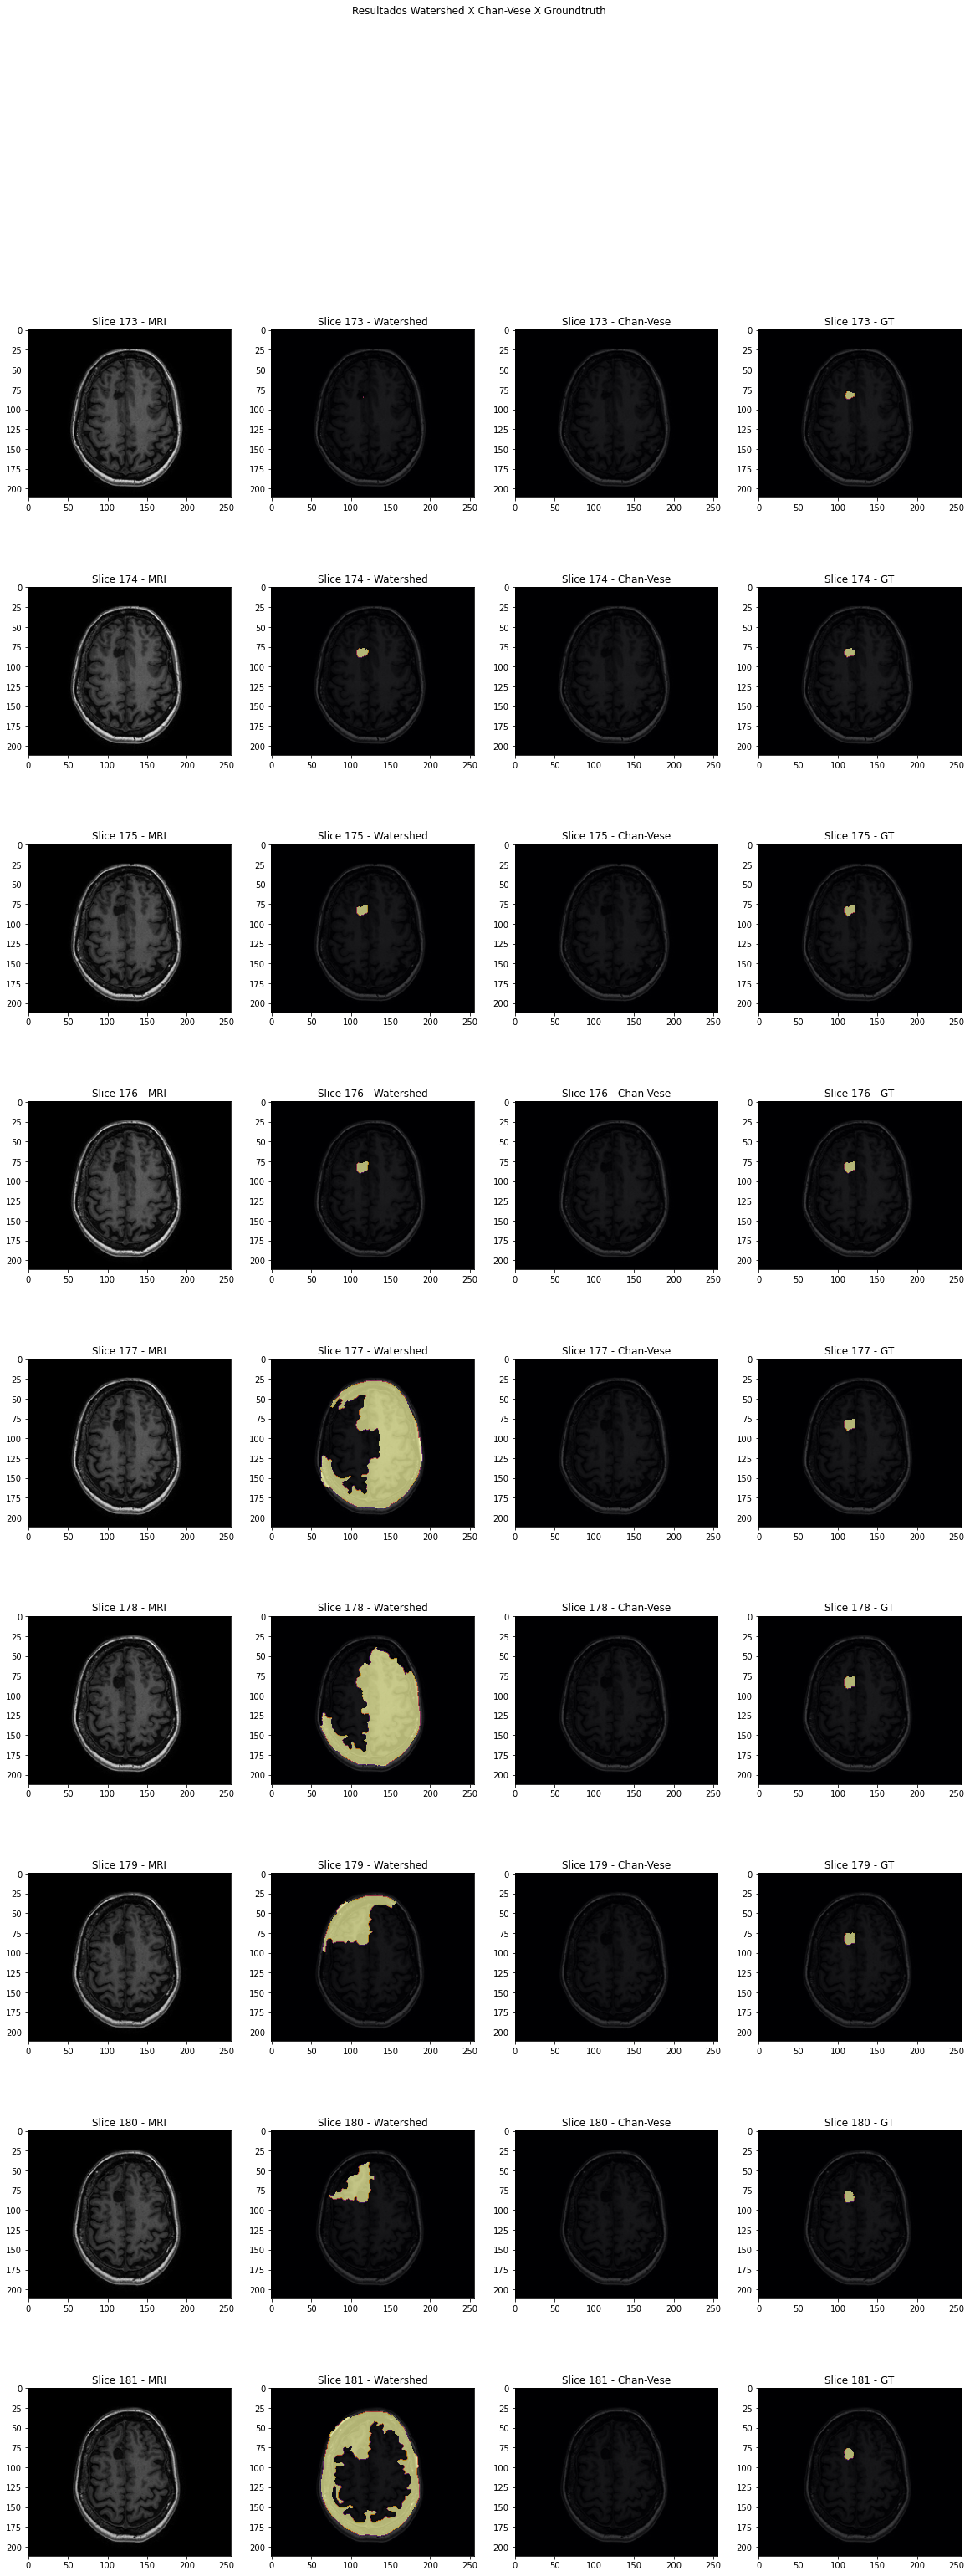

In [4]:
n_case = 0
case_test = CASES[n_case]
sub_id = case_test['subject_id']
slices_range = case_test['slice_range']
perspective = case_test['perspective']
norm_thres = case_test['norm_thres']
morphy = case_test['apply_morphy']
x = case_test['x']
y = case_test['y']
outer_x = case_test['outer_mark_x']
outer_y = case_test['outer_mark_y']
mu = case_test['mu']
lambda1 = case_test['lambda1']
lambda2 = case_test['lambda2']

print('==========Parametros gerais=============')
print(f'Id do Subject: {sub_id}')
print(f'Intervalo de slices: {slices_range}')
print(f'Perspectiva dos slices: {perspective}')
print(f'Coordanada X da semente: {x}')
print(f'Coordanada Y da semente: {y}')
print('\n==========Parametros Watershed=============')
print(f'Threshold de pré-processamento: {norm_thres}')
print(f'Pré-processamentos definidos e seus respectivos parametros:')
for key in morphy:
    print(f'   Pré-processamento: {key}')
    print(f'   Parametros:\n    {morphy[key]}')

print(f'Coordanada X da semente externa: {outer_x}')
print(f'Coordanada Y da semente: {outer_y}')

print('\n==========Parametros Chan Vese=============')
print(f'Mu: {mu}')
print(f'Lambda1: {lambda1}')
print(f'Lambda2: {lambda2}')

# Get the mri images slices from the desired subject
slices_array = get_batch_data(df, sub_id, slices_range, perspective)
mri_slices = []

for slices in slices_array:
    mri_slices.append(utils.normalize_img(slices))
# Get the groundtruth masks from the slices examinated
masks_array = get_batch_data(df, sub_id, slices_range, perspective, True)

masks_chan_vese, dices_chan = apply_batch_chan_vese(df, sub_id, slices_range, perspective,
                                           mu, lambda1, lambda2, x, y, n_case)
masks_watershed, dices_water = apply_batch_watershed(df, sub_id, slices_range,
                                            perspective, norm_thres, morphy, x,
                                            y, outer_x, outer_y, n_case)
        
#dices_scores_chan_vese.append(dices_chan)
#dices_scores_watershed.append(dices_water)
resulting_slices = [mri_slices, masks_watershed, masks_chan_vese, masks_array]
plot_mosaic(resulting_slices, slices_range, 'Resultados Watershed X Chan-Vese X Groundtruth')

In [5]:
i = 0
s_start, s_end = slices_range
print(f'====================: Watershed  || Chan Vese')
for s in range(s_start, s_end):
    print(f'Slice {s} dice score:    {dices_water[i]:0.4f}  ||    {dices_chan[i]:0.4f}')
    i += 1
print(f'\n============== Média:    {dices_water.mean():0.4f}  ||    {dices_chan.mean():0.4f}')


====================: Watershed  || Chan Vese
Slice 173 dice score:    0.0222  ||    0.0000
Slice 174 dice score:    0.9339  ||    0.0000
Slice 175 dice score:    0.9424  ||    0.0000
Slice 176 dice score:    0.9515  ||    0.0000
Slice 177 dice score:    0.0310  ||    0.0000
Slice 178 dice score:    0.0374  ||    0.0000
Slice 179 dice score:    0.1161  ||    0.0000
Slice 180 dice score:    0.2134  ||    0.0000
Slice 181 dice score:    0.0360  ||    0.0000

============== Média:    0.3649  ||    0.0000


## Caso 2

In [ ]:
n_case = 1
case_test = CASES[n_case]
sub_id = case_test['subject_id']
slices_range = case_test['slice_range']
perspective = case_test['perspective']
norm_thres = case_test['norm_thres']
morphy = case_test['apply_morphy']
x = case_test['x']
y = case_test['y']
outer_x = case_test['outer_mark_x']
outer_y = case_test['outer_mark_y']
mu = case_test['mu']
lambda1 = case_test['lambda1']
lambda2 = case_test['lambda2']

print('==========Parametros gerais=============')
print(f'Id do Subject: {sub_id}')
print(f'Intervalo de slices: {slices_range}')
print(f'Perspectiva dos slices: {perspective}')
print(f'Coordanada X da semente: {x}')
print(f'Coordanada Y da semente: {y}')
print('\n==========Parametros Watershed=============')
print(f'Threshold de pré-processamento: {norm_thres}')
print(f'Pré-processamentos definidos e seus respectivos parametros:')
for key in morphy:
    print(f'   Pré-processamento: {key}')
    print(f'   Parametros:\n    {morphy[key]}')

print(f'Coordanada X da semente externa: {outer_x}')
print(f'Coordanada Y da semente: {outer_y}')

print('\n==========Parametros Chan Vese=============')
print(f'Mu: {mu}')
print(f'Lambda1: {lambda1}')
print(f'Lambda2: {lambda2}')

# Get the mri images slices from the desired subject
slices_array = get_batch_data(df, sub_id, slices_range, perspective)
mri_slices = []

for slices in slices_array:
    mri_slices.append(utils.normalize_img(slices))
# Get the groundtruth masks from the slices examinated
masks_array = get_batch_data(df, sub_id, slices_range, perspective, True)

masks_chan_vese, dices_chan = apply_batch_chan_vese(df, sub_id, slices_range, perspective,
                                           mu, lambda1, lambda2, x, y, n_case)
masks_watershed, dices_water = apply_batch_watershed(df, sub_id, slices_range,
                                            perspective, norm_thres, morphy, x,
                                            y, outer_x, outer_y, n_case)
        
#dices_scores_chan_vese.append(dices_chan)
#dices_scores_watershed.append(dices_water)
resulting_slices = [mri_slices, masks_watershed, masks_chan_vese, masks_array]
plot_mosaic(resulting_slices, slices_range, 'Resultados Watershed X Chan-Vese X Groundtruth')

In [ ]:
i = 0
s_start, s_end = slices_range
print(f'====================: Watershed  || Chan Vese')
for s in range(s_start, s_end):
    print(f'Slice {s} dice score:    {dices_water[i]:0.4f}  ||    {dices_chan[i]:0.4f}')
    i += 1
print(f'\n============== Média:    {dices_water.mean():0.4f}  ||    {dices_chan.mean():0.4f}')


In [ ]:
n_case = 2
case_test = CASES[n_case]
sub_id = case_test['subject_id']
slices_range = case_test['slice_range']
perspective = case_test['perspective']
norm_thres = case_test['norm_thres']
morphy = case_test['apply_morphy']
x = case_test['x']
y = case_test['y']
outer_x = case_test['outer_mark_x']
outer_y = case_test['outer_mark_y']
mu = case_test['mu']
lambda1 = case_test['lambda1']
lambda2 = case_test['lambda2']

print('==========Parametros gerais=============')
print(f'Id do Subject: {sub_id}')
print(f'Intervalo de slices: {slices_range}')
print(f'Perspectiva dos slices: {perspective}')
print(f'Coordanada X da semente: {x}')
print(f'Coordanada Y da semente: {y}')
print('\n==========Parametros Watershed=============')
print(f'Threshold de pré-processamento: {norm_thres}')
print(f'Pré-processamentos definidos e seus respectivos parametros:')
for key in morphy:
    print(f'   Pré-processamento: {key}')
    print(f'   Parametros:\n    {morphy[key]}')

print(f'Coordanada X da semente externa: {outer_x}')
print(f'Coordanada Y da semente: {outer_y}')

print('\n==========Parametros Chan Vese=============')
print(f'Mu: {mu}')
print(f'Lambda1: {lambda1}')
print(f'Lambda2: {lambda2}')

# Get the mri images slices from the desired subject
slices_array = get_batch_data(df, sub_id, slices_range, perspective)
mri_slices = []

for slices in slices_array:
    mri_slices.append(utils.normalize_img(slices))
# Get the groundtruth masks from the slices examinated
masks_array = get_batch_data(df, sub_id, slices_range, perspective, True)

masks_chan_vese, dices_chan = apply_batch_chan_vese(df, sub_id, slices_range, perspective,
                                           mu, lambda1, lambda2, x, y, n_case)
masks_watershed, dices_water = apply_batch_watershed(df, sub_id, slices_range,
                                            perspective, norm_thres, morphy, x,
                                            y, outer_x, outer_y, n_case)
        
#dices_scores_chan_vese.append(dices_chan)
#dices_scores_watershed.append(dices_water)
resulting_slices = [mri_slices, masks_watershed, masks_chan_vese, masks_array]
plot_mosaic(resulting_slices, slices_range, 'Resultados Watershed X Chan-Vese X Groundtruth')

In [ ]:
i = 0
s_start, s_end = slices_range
print(f'====================: Watershed  || Chan Vese')
for s in range(s_start, s_end):
    print(f'Slice {s} dice score:    {dices_water[i]:0.4f}  ||    {dices_chan[i]:0.4f}')
    i += 1
print(f'\n============== Média:    {dices_water.mean():0.4f}  ||    {dices_chan.mean():0.4f}')

In [ ]:
n_case = 3
case_test = CASES[n_case]
sub_id = case_test['subject_id']
slices_range = case_test['slice_range']
perspective = case_test['perspective']
norm_thres = case_test['norm_thres']
morphy = case_test['apply_morphy']
x = case_test['x']
y = case_test['y']
outer_x = case_test['outer_mark_x']
outer_y = case_test['outer_mark_y']
mu = case_test['mu']
lambda1 = case_test['lambda1']
lambda2 = case_test['lambda2']

print('==========Parametros gerais=============')
print(f'Id do Subject: {sub_id}')
print(f'Intervalo de slices: {slices_range}')
print(f'Perspectiva dos slices: {perspective}')
print(f'Coordanada X da semente: {x}')
print(f'Coordanada Y da semente: {y}')
print('\n==========Parametros Watershed=============')
print(f'Threshold de pré-processamento: {norm_thres}')
print(f'Pré-processamentos definidos e seus respectivos parametros:')
for key in morphy:
    print(f'   Pré-processamento: {key}')
    print(f'   Parametros:\n    {morphy[key]}')

print(f'Coordanada X da semente externa: {outer_x}')
print(f'Coordanada Y da semente: {outer_y}')

print('\n==========Parametros Chan Vese=============')
print(f'Mu: {mu}')
print(f'Lambda1: {lambda1}')
print(f'Lambda2: {lambda2}')

# Get the mri images slices from the desired subject
slices_array = get_batch_data(df, sub_id, slices_range, perspective)
mri_slices = []

for slices in slices_array:
    mri_slices.append(utils.normalize_img(slices))
# Get the groundtruth masks from the slices examinated
masks_array = get_batch_data(df, sub_id, slices_range, perspective, True)

masks_chan_vese, dices_chan = apply_batch_chan_vese(df, sub_id, slices_range, perspective,
                                           mu, lambda1, lambda2, x, y, n_case)
masks_watershed, dices_water = apply_batch_watershed(df, sub_id, slices_range,
                                            perspective, norm_thres, morphy, x,
                                            y, outer_x, outer_y, n_case)
        
#dices_scores_chan_vese.append(dices_chan)
#dices_scores_watershed.append(dices_water)
resulting_slices = [mri_slices, masks_watershed, masks_chan_vese, masks_array]
plot_mosaic(resulting_slices, slices_range, 'Resultados Watershed X Chan-Vese X Groundtruth')

In [ ]:
i = 0
s_start, s_end = slices_range
print(f'====================: Watershed  || Chan Vese')
for s in range(s_start, s_end):
    print(f'Slice {s} dice score:    {dices_water[i]:0.4f}  ||    {dices_chan[i]:0.4f}')
    i += 1
print(f'\n============== Média:    {dices_water.mean():0.4f}  ||    {dices_chan.mean():0.4f}')